In [22]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import requests
import time
import logging
import praw
from datetime import datetime, timedelta
from dotenv import load_dotenv
import os

import pyarrow as pa
import pyarrow.parquet as pq

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException
from bs4 import BeautifulSoup

To run this file with Docker:

docker run -p 8888:8888 -v $(pwd):/home/jovyan/work --env-file .env ubisoft-pipeline

# Data Collection

## 1. Ubisoft (UBI.PA) Stock Price - Yahoo Finance

In [25]:
# Define the Ubisoft ticker on Euronext Paris
ticker_symbol = "UBI.PA"

# Create the Ticker object
ubisoft = yf.Ticker(ticker_symbol)

# Fetch historical price data
# For scalability, the period can be changed to a longer period or a specified timeframe
ubisoft_hist = ubisoft.history(period="1y", interval="1d")

# Preview the data
ubisoft_hist.info()
print(ubisoft_hist.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 258 entries, 2024-04-04 00:00:00+02:00 to 2025-04-04 00:00:00+02:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          258 non-null    float64
 1   High          258 non-null    float64
 2   Low           258 non-null    float64
 3   Close         258 non-null    float64
 4   Volume        258 non-null    int64  
 5   Dividends     258 non-null    float64
 6   Stock Splits  258 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 16.1 KB
                                Open       High        Low      Close  Volume  \
Date                                                                            
2024-04-04 00:00:00+02:00  19.820000  19.975000  19.520000  19.860001  357334   
2024-04-05 00:00:00+02:00  19.549999  19.815001  19.120001  19.815001  496791   
2024-04-08 00:00:00+02:00  19.840000  20.700001  19.825001  20.700001  863889   
2024

Normalise Date variable.

In [34]:
# Reset index so 'Date' becomes a regular column
ubisoft_hist = ubisoft_hist.reset_index()

# Rename the column 
ubisoft_hist.rename(columns={'index': 'Date'}, inplace=True)

# Convert to datetime with timezone-awareness removed
ubisoft_hist['Date'] = pd.to_datetime(ubisoft_hist['Date']).dt.tz_localize(None)

# Print to confirm
ubisoft_hist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          258 non-null    datetime64[ns]
 1   Open          258 non-null    float64       
 2   High          258 non-null    float64       
 3   Low           258 non-null    float64       
 4   Close         258 non-null    float64       
 5   Volume        258 non-null    int64         
 6   Dividends     258 non-null    float64       
 7   Stock Splits  258 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 16.3 KB


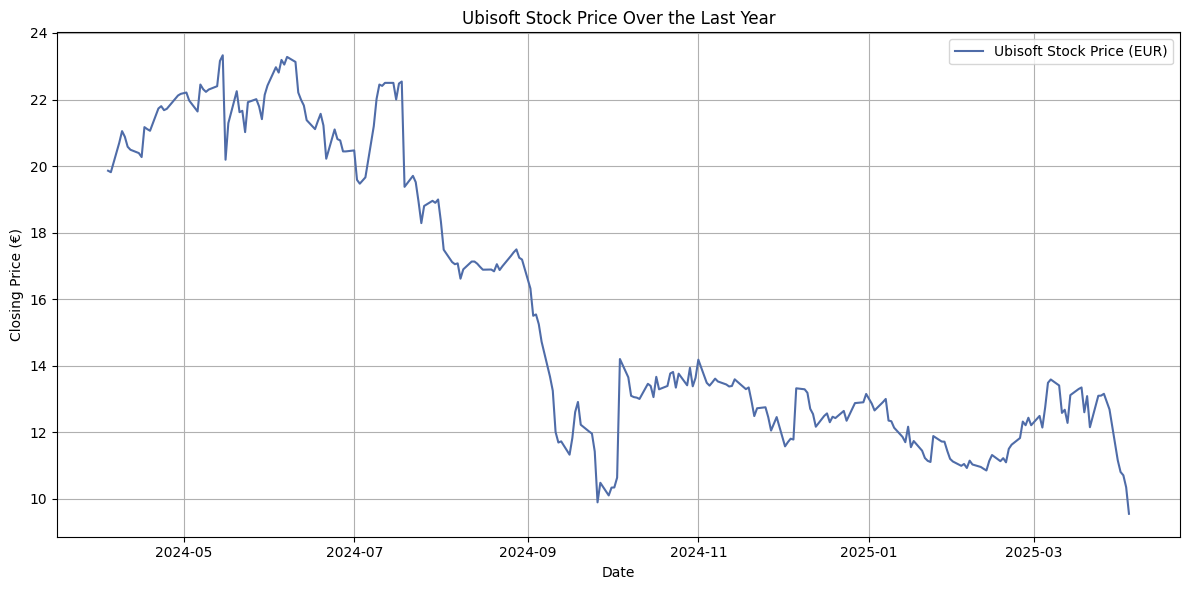

In [35]:
# Load Ubisoft stock data
ubisoft = yf.Ticker("UBI.PA")
hist = ubisoft.history(period="1y", interval="1d")

# Plot closing price
plt.figure(figsize=(12, 6))
plt.plot(hist.index, hist["Close"], label="Ubisoft Stock Price (EUR)", color="#4F6CA8")
plt.title("Ubisoft Stock Price Over the Last Year")
plt.xlabel("Date")
plt.ylabel("Closing Price (€)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## 2. Ubisoft Event Timeline

In [29]:
# Set cutoff date
since_date = datetime(2024, 4, 1)

# Setup headless Chrome
options = Options()
options.add_argument('--headless')
options.add_argument('--disable-gpu')
options.add_argument('--no-sandbox')
options.add_argument('user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.85 Safari/537.36')
driver = webdriver.Chrome(options=options)

# Load Ubisoft news page
url = 'https://news.ubisoft.com/en-gb/'
driver.get(url)
time.sleep(3)

# Init variables
news_data = []
page = 1
stop_scraping = False

while not stop_scraping:
    print(f"Scraping page {page}...")

    # Parse current page
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    articles = soup.find_all('div', class_='updatesPagination__item__wrapper')

    for article in articles:
        headline_tag = article.find('h2', class_='updatesPagination__item__wrapper__content__title')
        headline = headline_tag.text.strip() if headline_tag else None

        date_span = article.find('span', class_='date')
        if not date_span:
            continue

        try:
            day = date_span.find('span', class_='date__day').text.strip()
            month = date_span.find('span', class_='date__month').text.strip()
            year = date_span.find('span', class_='date__year').text.strip()
            pub_date = datetime.strptime(f"{day} {month} {year}", "%d %B %Y")
        except Exception:
            continue

        if pub_date < since_date:
            stop_scraping = True
            break

        news_data.append({
            'date': pub_date.strftime("%Y-%m-%d"),
            'headline': headline
        })

    if stop_scraping:
        break

    # Click next page button
    page += 1
    try:
        next_button = driver.find_element(By.XPATH, f'//button[@class="pagination__pageNumber__button" and @data-innertext="{page}"]')
        driver.execute_script("arguments[0].click();", next_button)
        time.sleep(2)
    except NoSuchElementException:
        print(f"No more pages after {page-1}.")
        break

# Close driver
driver.quit()

# Store as DataFrame
ubisoft_news_df = pd.DataFrame(news_data)

Scraping page 1...
Scraping page 2...
Scraping page 3...
Scraping page 4...
Scraping page 5...
Scraping page 6...
Scraping page 7...
Scraping page 8...
Scraping page 9...
Scraping page 10...
Scraping page 11...
Scraping page 12...
Scraping page 13...
Scraping page 14...
Scraping page 15...
Scraping page 16...
Scraping page 17...
Scraping page 18...
Scraping page 19...
Scraping page 20...


In [30]:
ubisoft_news_df.info()
ubisoft_news_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      156 non-null    object
 1   headline  156 non-null    object
dtypes: object(2)
memory usage: 2.6+ KB


,date,headline
0,2025-04-02,Star Wars Outlaws Coming to Nintendo Switch 2 ...
1,2025-03-27,Prince of Persia: The Lost Crown Coming to Mob...
2,2025-03-26,Watch Side Quest on Apple TV+ Today
3,2025-03-26,Play the Brawlhalla: Guardians Crossover Event...
4,2025-03-21,Ubisoft Announces It Is a Founding Member of t...


## 3 Product (Video Game) Reviews
### 3.1 Steam Reviews

In [7]:
# Configure logging for error awareness and debugging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Set up SteamDB AppID
appid = "3159330"  # AppID for Assassin's Creed Shadows
base_url = f"https://store.steampowered.com/appreviews/{appid}"  # Base URL for the Steam review API

# Define API parameters
params = {
    "json": 1,
    "filter": "recent",       # Options: 'recent' or 'all'
    "language": "english",    # Language filter for reviews
    "day_range": 365,         # Fetch reviews from the last 365 days
    "review_type": "all",     # Options: 'all', 'positive', 'negative'
    "purchase_type": "all",   # Options: 'all', 'steam', 'non_steam'
    "num_per_page": 100,      # Number of reviews per page
    "cursor": "*"             # Initial cursor value for pagination
}

# Storage for the collected reviews
steam_reviews = []
cursor = "*"  # Start cursor for pagination
previous_count = 0 # Track previous number of reviews

# Loop to fetch all pages of reviews
while cursor:

    # Log and display progress during runtime
    logging.info(f"Page {len(steam_reviews) // params['num_per_page'] + 1} - Total reviews collected: {len(steam_reviews)}")
    params["cursor"] = cursor
    try:
        # Make the API request with a timeout to avoid hanging indefinitely
        response = requests.get(base_url, params=params, timeout=10)
        response.raise_for_status()  # Raise an error for HTTP status codes 4xx/5xx
    except requests.exceptions.RequestException as e:
        logging.error(f"Request failed: {e}")
        break

    try:
        # Parse the JSON response
        data = response.json()
    except ValueError as e:
        logging.error(f"Error parsing JSON: {e}")
        break

    # Check if 'reviews' key exists in the JSON response
    if "reviews" not in data:
        logging.warning("No reviews found in the response. Exiting pagination loop.")
        break

    # Process each review entry in the current page
    for r in data["reviews"]:
        # Safely access the 'author' details, defaulting to an empty dict if missing
        author = r.get("author", {})

        # Append the structured review data to our list, using .get() for safe access
        steam_reviews.append({
            "review_id": r.get("recommendationid"),
            "language": r.get("language"),
            "review": r.get("review"),
            "voted_up": r.get("voted_up"),
            "votes_helpful": r.get("votes_helpful", 0),  # Default to 0 if missing
            "votes_funny": r.get("votes_funny", 0),        # Default to 0 if missing
            "timestamp_created": r.get("timestamp_created"),
            "steamid": author.get("steamid"),
            "playtime_forever": author.get("playtime_forever", 0)  # Default to 0 if missing
        })

    # Update the cursor for the next page
    cursor = data.get("cursor")  # Fetch the next page cursor, if available

    # If no cursor is found, it means we've reached the last page
    if not cursor:
        logging.info("No more reviews to fetch. Ending pagination.")
        break

    # Sleep to avoid hitting rate limits
    time.sleep(3)

    # Break if review count has stopped growing
    current_count = len(steam_reviews)
    if current_count == previous_count:
        logging.info("No new reviews collected in this iteration. Ending loop.")
        break
    previous_count = current_count  # Update tracker

# Convert the list of review dictionaries into a DataFrame
steam_reviews_df = pd.DataFrame(steam_reviews)

logging.info(f"Collected {len(steam_reviews_df)} reviews.")

INFO: Page 1 - Total reviews collected: 0


INFO: Page 2 - Total reviews collected: 100
INFO: Page 3 - Total reviews collected: 200
INFO: Page 4 - Total reviews collected: 300
INFO: Page 5 - Total reviews collected: 400
INFO: Page 6 - Total reviews collected: 500
INFO: Page 7 - Total reviews collected: 600
INFO: Page 8 - Total reviews collected: 700
INFO: Page 9 - Total reviews collected: 800
INFO: Page 10 - Total reviews collected: 900
INFO: Page 11 - Total reviews collected: 1000
INFO: Page 12 - Total reviews collected: 1100
INFO: Page 13 - Total reviews collected: 1200
INFO: Page 14 - Total reviews collected: 1300
INFO: Page 15 - Total reviews collected: 1400
INFO: Page 16 - Total reviews collected: 1500
INFO: Page 17 - Total reviews collected: 1600
INFO: Page 18 - Total reviews collected: 1700
INFO: Page 19 - Total reviews collected: 1800
INFO: Page 20 - Total reviews collected: 1900
INFO: Page 21 - Total reviews collected: 2000
INFO: Page 22 - Total reviews collected: 2100
INFO: Page 23 - Total reviews collected: 2200
INFO:

In [8]:
# Check for duplicated rows
num_duplicates = steam_reviews_df.duplicated().sum()

# Print the number of duplicated rows
print(f"Number of duplicated rows: {num_duplicates}")

Number of duplicated rows: 0


In [9]:
# Convert the list of review dictionaries into a DataFrame
steam_reviews_df = pd.DataFrame(steam_reviews)

# Convert collected raw data into readable units
steam_reviews_df["review_date"] = pd.to_datetime(steam_reviews_df["timestamp_created"], unit="s")
steam_reviews_df["playtime_hours"] = (steam_reviews_df["playtime_forever"] / 60).round(2)

# Drop original raw data
steam_reviews_df = steam_reviews_df.drop(columns=["timestamp_created", "playtime_forever"])

In [10]:
# Preview the collected data
steam_reviews_df.info()
steam_reviews_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7733 entries, 0 to 7732
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   review_id       7733 non-null   object        
 1   language        7733 non-null   object        
 2   review          7733 non-null   object        
 3   voted_up        7733 non-null   bool          
 4   votes_helpful   7733 non-null   int64         
 5   votes_funny     7733 non-null   int64         
 6   steamid         7733 non-null   object        
 7   review_date     7733 non-null   datetime64[ns]
 8   playtime_hours  7733 non-null   float64       
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 491.0+ KB


,review_id,language,review,voted_up,votes_helpful,votes_funny,steamid,review_date,playtime_hours
0,192017461,english,Its fun.,True,0,0,76561198866573425,2025-04-05 05:39:03,32.83
1,192017163,english,"""same shit different toilet""",False,0,0,76561199069674958,2025-04-05 05:32:42,23.45
2,192017026,english,I was a huge ac fan all the way back from AC 2...,False,0,0,76561198076590691,2025-04-05 05:29:52,12.83
3,192016829,english,"very good, Assassins creed in Japan has been a...",True,0,0,76561198189976275,2025-04-05 05:25:28,37.20
4,192016602,english,a piece of shit,False,0,0,76561199525894066,2025-04-05 05:20:40,0.22


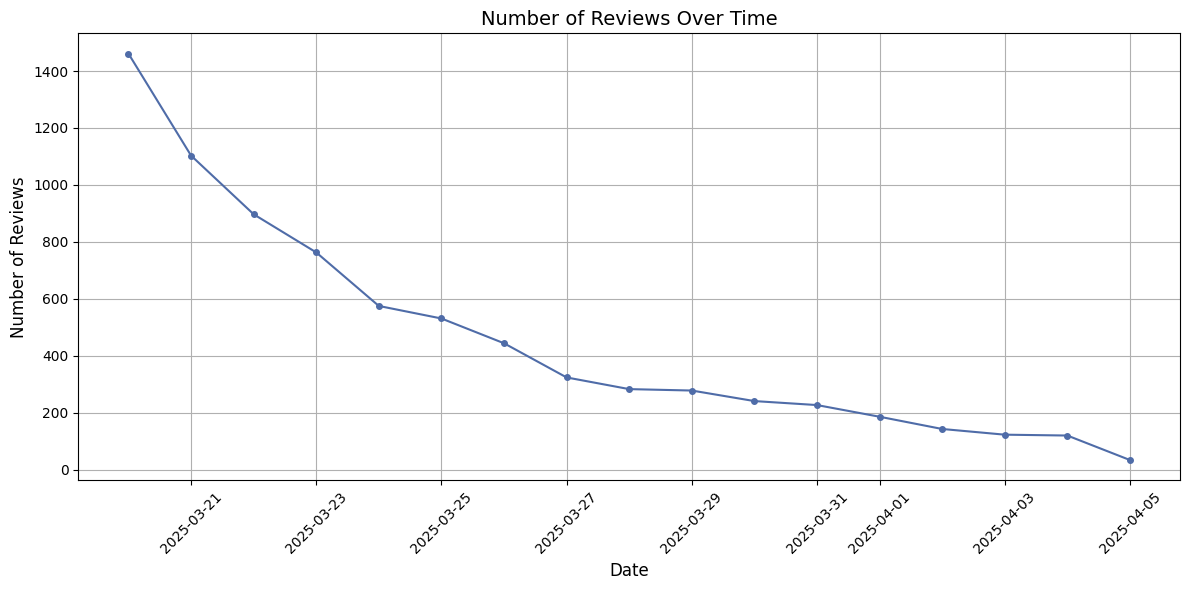

In [11]:
# Group by review date (daily)
reviews_per_day = steam_reviews_df.groupby(steam_reviews_df["review_date"].dt.date).size()

# Plot the number of reviews per day
plt.figure(figsize=(12, 6))
plt.plot(reviews_per_day.index, reviews_per_day.values, marker='o', color='#4F6CA8', linestyle='-', markersize=4)

# Add labels and title
plt.title("Number of Reviews Over Time", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

### 3.2 Reddit Game Reviews

In [13]:
# Load credentials from local .env
load_dotenv()

CLIENT_ID = os.getenv("REDDIT_CLIENT_ID")
CLIENT_SECRET = os.getenv("REDDIT_CLIENT_SECRET")
APP_NAME = os.getenv("REDDIT_USER_AGENT")

In [15]:
def scrape_reddit(subreddit_name, start_date, max_total_posts, max_days=15):
    """
    Scrape Reddit posts and comments from a subreddit within a specific date range.

    Parameters:
        subreddit_name (str): Target subreddit to scrape.
        start_date (datetime): Starting date for scraping.
        max_total_posts (int): Maximum total number of posts to scrape.
        max_days (int): Time window in days (default = 15).

    Returns:
        reddit_posts_df (pd.DataFrame): DataFrame of scraped posts.
        reddit_comments_df (pd.DataFrame): DataFrame of scraped comments.
    """
    
    # Initialize PRAW
    reddit = praw.Reddit(
        client_id=CLIENT_ID,
        client_secret=CLIENT_SECRET,
        user_agent=APP_NAME
    )

    subreddit = reddit.subreddit(subreddit_name)

    # Time window
    end_date = start_date + timedelta(days=max_days)
    start_ts = start_date.timestamp()
    end_ts = end_date.timestamp()

    posts = []
    comments = []

    print(f"Collecting posts from {start_date.date()} to {end_date.date()}...")

    # Fetch new posts, filter by date
    for post in subreddit.hot(limit=None):
        if len(posts) >= max_total_posts:
            break

        # Filter by timestamp window
        if start_ts <= post.created_utc <= end_ts:
            try:
                post.comments.replace_more(limit=0)
            except Exception as e:
                print(f"Error loading comments for post {post.id}: {e}")
                continue

            posts.append({
                "id": post.id,
                "title": post.title,
                "selftext": post.selftext,
                "created_utc": post.created_utc,
                "created_date": datetime.utcfromtimestamp(post.created_utc),
                "score": post.score,
                "num_comments": post.num_comments,
                "url": post.url
            })

            for comment in post.comments.list():
                comments.append({
                    "post_id": post.id,
                    "comment_id": comment.id,
                    "comment_body": comment.body,
                    "comment_score": comment.score,
                    "comment_author": str(comment.author),
                    "comment_created_utc": comment.created_utc,
                    "comment_created_date": datetime.utcfromtimestamp(comment.created_utc)
                })

    print(f"Collected {len(posts)} posts and {len(comments)} comments.")

    # Convert to dataframes
    reddit_posts_df = pd.DataFrame(posts)
    reddit_comments_df = pd.DataFrame(comments)

    # Drop unneeded original datetime info
    reddit_posts_df = reddit_posts_df.drop(columns="created_utc")
    reddit_comments_df = reddit_comments_df.drop(columns="comment_created_utc")

    return reddit_posts_df, reddit_comments_df

In [16]:
# Set parameters
start_date = datetime(2025, 3, 20)
max_total_posts = 1000
max_days = 15
subreddit_name = "AssassinsCreedShadows"

# Call on function to collect data from Reddit
acshadows_reddit_posts_df, acshadows_reddit_comments_df = scrape_reddit(subreddit_name, start_date, max_total_posts, max_days)

Collected 619 posts and 7590 comments.


In [17]:
acshadows_reddit_posts_df.info()
acshadows_reddit_posts_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619 entries, 0 to 618
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            619 non-null    object        
 1   title         619 non-null    object        
 2   selftext      619 non-null    object        
 3   created_date  619 non-null    datetime64[ns]
 4   score         619 non-null    int64         
 5   num_comments  619 non-null    int64         
 6   url           619 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 34.0+ KB


,id,title,selftext,created_date,score,num_comments,url
0,1jjm9ke,AC Shadows title update 1.0.1 (Hotfix) - Relea...,"Hello Assassins, thank you so much for all the...",2025-03-25 15:37:17,311,287,https://i.redd.it/f3bl7bw6vuqe1.jpeg
1,1jfjvnx,[Megathread] Discuss Main Game Spoilers Here,"Hello everyone,\n\nThis megathread is dedicate...",2025-03-20 08:03:22,6,53,https://www.reddit.com/r/AssassinsCreedShadows...
2,1jqvtwz,I so wish we could build a hot spring in the c...,One thing I loved from Ghost of Tsushima was c...,2025-04-03 22:10:14,608,201,https://i.redd.it/pgsr256i1pse1.jpeg
3,1jqtfht,Selfie time,,2025-04-03 20:33:49,448,10,https://i.redd.it/2zbgofrakose1.jpeg
4,1jqwxf4,I sailed from Obama to Miyazu Bay and it made ...,I MISS MY BOATS.\n\nI miss the skald that play...,2025-04-03 22:58:25,206,96,https://www.reddit.com/gallery/1jqwxf4


In [18]:
acshadows_reddit_comments_df.info()
acshadows_reddit_comments_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7590 entries, 0 to 7589
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   post_id               7590 non-null   object        
 1   comment_id            7590 non-null   object        
 2   comment_body          7590 non-null   object        
 3   comment_score         7590 non-null   int64         
 4   comment_author        7590 non-null   object        
 5   comment_created_date  7590 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 355.9+ KB


,post_id,comment_id,comment_body,comment_score,comment_author,comment_created_date
0,1jjm9ke,mjogrpx,Does anyone else wish you could just sit down ...,171,_MostPalone_,2025-03-25 16:37:25
1,1jjm9ke,mjo4lcz,"View in your timezone: \n[Mar 25, 18:00 UTC][...",23,timee_bot,2025-03-25 15:37:33
2,1jjm9ke,mjoy7n7,Hope they fixed were your sheath disappears fo...,23,Ok_Construction2434,2025-03-25 17:49:15
3,1jjm9ke,mjpqkqt,Hopefully it fixes the Tools Master “throw an ...,34,grizzy77,2025-03-25 20:07:30
4,1jjm9ke,mjqy5d9,Weather system is phenomenal,10,s2keddie,2025-03-25 23:48:58


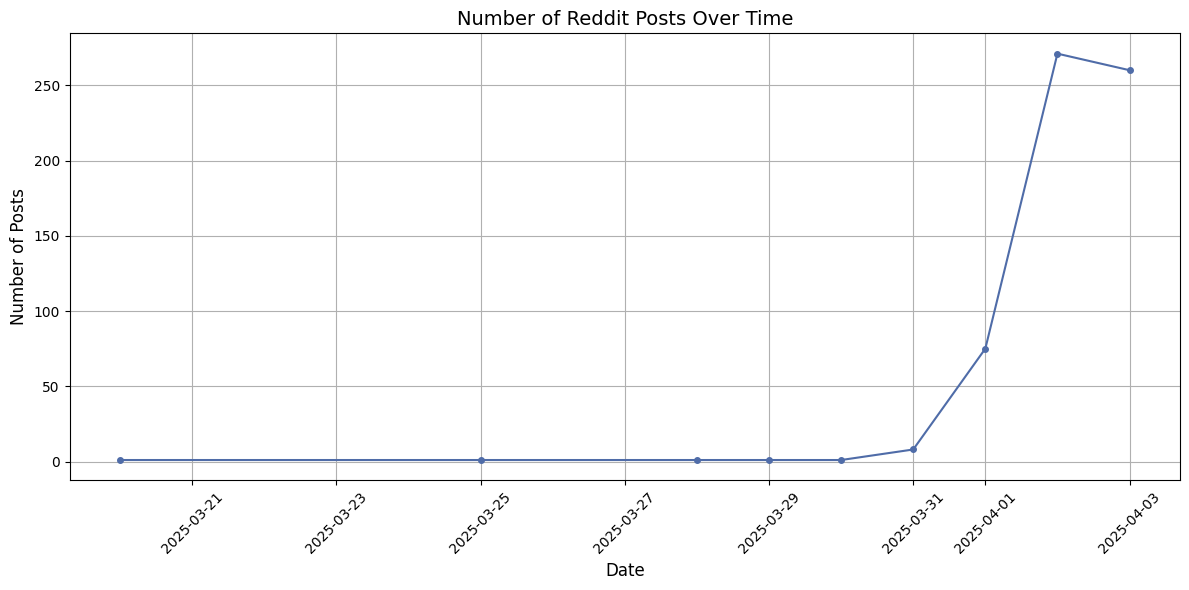

In [20]:
# Group by review date (daily)
posts_per_day = acshadows_reddit_posts_df.groupby(acshadows_reddit_posts_df["created_date"].dt.date).size()

# Plot the number of reviews per day
plt.figure(figsize=(12, 6))
plt.plot(posts_per_day.index, posts_per_day.values, marker='o', color='#4F6CA8', linestyle='-', markersize=4)

# Add labels and title
plt.title("Number of Reddit Posts Over Time", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Posts", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

## 4. Save as Parquet Files

Convert timestamp to microsecond, remove nanosecond. 

It was noticed during initial spark.read.parquet that some files contain timestamps saved with nanosecond precision. To resolve this:

In [37]:
# Convert datetime variables to microsecond precision
ubisoft_hist['Date'] = ubisoft_hist['Date'].astype('datetime64[us]')

ubisoft_news_df['date'] = pd.to_datetime(ubisoft_news_df['date']).astype('datetime64[us]')

steam_reviews_df['review_date'] = steam_reviews_df['review_date'].astype('datetime64[us]')

acshadows_reddit_posts_df['created_date'] = acshadows_reddit_posts_df['created_date'].astype('datetime64[us]')

acshadows_reddit_comments_df['comment_created_date'] = acshadows_reddit_comments_df['comment_created_date'].astype('datetime64[us]')

In [38]:
# Save to Parquet
ubisoft_hist.to_parquet("data/ubisoft_stock.parquet")
ubisoft_news_df.to_parquet("data/ubisoft_news.parquet")
steam_reviews_df.to_parquet("data/steam_reviews.parquet")
acshadows_reddit_posts_df.to_parquet("data/acshadows_reddit_posts.parquet", index=False)
acshadows_reddit_comments_df.to_parquet("data/acshadows_reddit_comments.parquet", index=False)